In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask_jobqueue
import dask
from distributed import Client
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import intake
import fsspec
import gcsfs
import cftime
import pandas as pd
import xesmf as xe
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
#import seaborn as sns
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# import logging
# logging.basicConfig(level=logging.DEBUG)  # Set logging level to DEBUG

/tmp/ipykernel_64573/1444969798.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')

In [3]:
################################
cesm2_path        = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals             = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
cmip6_cvals       = cvals + 'cmip6/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
date = no_leap_date(doy)

In [4]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [5]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(1)

In [6]:
cluster

Dashboard: http://10.0.2.2:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.2.2:44518,Workers: 0
Dashboard: http://10.0.2.2:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
chicago_lat=41.88
chicago_lon=(360-87.6298)%360
#
ben_lat      = 12.9716
ben_lon      = 77.5946
# #
# cvals_ = '/Users/hrh/Desktop/TwoMoments21/cvals/cmip6/'

In [8]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile'}
    return (ds * weight).mean(other_dims)

In [9]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


## Select only two models with comparable Equilibrium Climate Sensitivity

In [10]:
# 2. Search for daily maximum temperature from CMIP6 models
## Uncomment the lines with 'models' to get data from all models.
expts  = ['ssp370','historical']
models = ['MIROC6','GFDL-ESM4']
cat = col.search(
    experiment_id=expts,
    table_id='day',
    variable_id='tasmax',
    source_id = models,
    #grid_label='gn'
)

query = dict(
    experiment_id=expts,
    table_id='day',
    source_id = models,
    variable_id=['tasmax'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id","member_id"]
].nunique()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/intake_esm/_search.py:82: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,experiment_id,variable_id,table_id,member_id
source_id,,,,
GFDL-ESM4,2,1,1,1
MIROC6,2,1,1,1


In [11]:
df = col_subset.df
model_counts = df.groupby('source_id').size()
print(model_counts)

source_id
GFDL-ESM4    2
MIROC6       2
dtype: int64


In [12]:
#col_subset = col_subset.df[col_subset.df['source_id'=='MIROC6']]
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
1,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
2,CMIP,MIROC,MIROC6,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20191016
3,ScenarioMIP,MIROC,MIROC6,ssp370,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp3...,NaN,20191016


In [13]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [14]:
%%time
# Trigger computation
dsets_ = dask.compute(dict(dsets))[0]

CPU times: user 3.29 s, sys: 245 ms, total: 3.54 s
Wall time: 40.7 s


In [15]:
#Define coarse grid to regrid on
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1)),
                     'lon': (['lon'], np.arange(0, 361, 1)),})

In [16]:
def drop_feb29(ds):
    # Check if the dataset's calendar is not '360_day'
    calendar = ds.time.encoding.get('calendar', None)
    print(ds.attrs['source_id'],calendar)
    if calendar != '360_day':
        ds = ds.convert_calendar('365_day')
    return ds


def to_daily(ds):
    # Check and deal with different datetime types
    if isinstance(ds['time'].values[0], np.datetime64):
        pass
    elif isinstance(ds['time'].values[0], cftime.datetime):
        pass
    else:
        # convert time coordinate to datetime64 objects
        ds['time'] = ds['time'].astype('datetime64[ns]')
    year      = ds.time.dt.year
    dayofyear = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  


def extract_data(ds):
    """
    Extract data for djf from the dataset 'ds' for specific time and spatial range.

    Parameters:
    - ds (xarray.Dataset): Input dataset

    Returns:
    - xarray.Dataset: Dataset subsetted for djf and the specified space and time range.
    """    

    subset1 = ds.sel(year=slice(1850, 1879))
    subset2 = ds.sel(year=slice(2071, 2100))
    
    subset = xr.concat([subset1, subset2], dim='year')  

    return subset

def is_leap(year):
    """Check if a year is a leap year."""
    return (year % 4 == 0) and ((year % 100 != 0) or (year % 400 == 0))



In [9]:
quants = np.linspace(0,1.0,30)

def regrid(ds, ds_out):
    experiment_id = ds.attrs['experiment_id']
    source_id     = ds.attrs['source_id']
    #regrid
    regridder = xe.Regridder(ds, ds_out, 'nearest_s2d', reuse_weights=False)
    ds_new    = regridder(ds)
    
#     #Assign back attributes as regirdder would have deleted attributes 
    ds_new.attrs['experiment_id'] = experiment_id
    ds_new.attrs['source_id'] = source_id
    
    #print(ds_new.attrs['experiment_id'],ds_new.attrs['source_id'])
    #print(ds_new)
    return ds_new

def process_data(ds, quantiles=quants):
    ds = ds.pipe(drop_feb29).pipe(to_daily).pipe(extract_data)
    
    if len(ds['year']) == 0:
        print("The dataset is empty. Skipping...")
        return None
    
    if len(ds['dayofyear'])<365:
        print('The dataset has less than 365 days. Skipping ..')
        return None
    
    # # Remove 'time' coordinate
    # ds = ds.set_index(time=("year", "dayofyear")).unstack("time")  
   
    
    return (ds.pipe(regrid, ds_out=ds_out)
           )


In [18]:
with progress.ProgressBar():

    expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                           coords={'experiment_id': expts})

    # Initialize an Empty Dictionary for Aligned Datasets:
    dsets_aligned = {}

    # Iterate Over dsets_ Dictionary:

    for k, v in tqdm(dsets_.items()):
        # Initialize a dictionary for this source_id
        dsets_aligned[k] = {}
        
        skip_source_id = False

        for expt in expts:
            ds = v[expt].pipe(process_data)

            # Check if the dataset is empty and skip this source_id if so
            if ds is None:
                print(f"Skipping {expt} for {k} because the dataset is empty")
                skip_source_id = True
                break
            
            # Store the dataset in the dictionary
            # dsets_aligned[k][expt] = ds
            # Compute the dataset and store it in the dictionary
            dsets_aligned[k][expt] = ds.compute()
            print(dsets_aligned[k][expt])

        if skip_source_id:
            del dsets_aligned[k]
            continue


  0%|          | 0/2 [00:00<?, ?it/s]

GFDL-ESM4 noleap


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 181, lon: 361, bnds: 2)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * bnds       (bnds) float64 1.0 2.0
    height     float64 2.0
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 249.0 249.0 ... 258.4 258.4
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      GFDL-ESM4
GFDL-ESM4 noleap


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 181, lon: 361, bnds: 2)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * bnds       (bnds) float64 1.0 2.0
    height     float64 2.0
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 246.0 246.0 ... 242.3 242.3
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      GFDL-ESM4
MIROC6 gregorian
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 181, lon: 361)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) 

In [19]:
# with progress.ProgressBar():
#     dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [20]:
source_ids = list(dsets_aligned.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

# raw_ds = {expt: xr.concat([ds.get(expt, xr.Dataset()).reset_coords(drop=True)
#                              for ds in dsets_aligned.values()],
#                             dim=source_da)
#             for expt in expts}

raw_ds = {expt: xr.concat([ds[expt].reset_coords(drop=True)
                             for ds in dsets_aligned.values() if expt in ds and ds[expt] is not None],
                            dim=source_da, coords='minimal')
            for expt in expts}

raw_ds

{'ssp370': <xarray.Dataset>
 Dimensions:    (source_id: 2, year: 30, dayofyear: 365, lat: 181, lon: 361,
                 bnds: 2)
 Coordinates:
   * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
   * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
   * bnds       (bnds) float64 1.0 2.0
   * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
   * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
   * source_id  (source_id) <U9 'GFDL-ESM4' 'MIROC6'
 Data variables:
     tasmax     (source_id, year, dayofyear, lat, lon) float32 249.0 ... 268.7
 Attributes:
     regrid_method:  nearest_s2d
     experiment_id:  ssp370
     source_id:      GFDL-ESM4,
 'historical': <xarray.Dataset>
 Dimensions:    (source_id: 2, year: 30, dayofyear: 365, lat: 181, lon: 361,
                 bnds: 2)
 Coordinates:
   * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
   * dayofy

In [21]:
raw_ds_pi = xr.concat([ds['historical'].reset_coords(drop=True)
                                 for ds in dsets_aligned.values()],
                                dim=source_da)

raw_ds_eoc = xr.concat([ds['ssp370'].reset_coords(drop=True)
                             for ds in dsets_aligned.values()],
                            dim=source_da)
raw_ds_eoc

<xarray.Dataset>
Dimensions:    (source_id: 2, year: 30, dayofyear: 365, lat: 181, lon: 361,
                bnds: 2)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * bnds       (bnds) float64 1.0 2.0
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
  * source_id  (source_id) <U9 'GFDL-ESM4' 'MIROC6'
Data variables:
    tasmax     (source_id, year, dayofyear, lat, lon) float32 249.0 ... 268.7
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      GFDL-ESM4

In [24]:
# %%time
# raw_ds_pi.to_zarr(cmip6_cvals+'cmip6_pi_tmax_annual.zarr',mode='w')
# raw_ds_eoc.to_zarr(cmip6_cvals+'cmip6_eoc_tmax_annual.zarr',mode='w')

In [11]:
raw_ds_pi  = xr.open_zarr(cmip6_cvals+'cmip6_pi_tmax_annual.zarr').tasmax
raw_ds_eoc = xr.open_zarr(cmip6_cvals+'cmip6_eoc_tmax_annual.zarr').tasmax
raw_ds_pi

<xarray.DataArray 'tasmax' (source_id: 2, year: 30, dayofyear: 365, lat: 181,
                            lon: 361)>
dask.array<open_dataset-71a168cd23843b2fcdeaf14408999783tasmax, shape=(2, 30, 365, 181, 361), dtype=float32, chunksize=(1, 4, 46, 46, 91), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
  * source_id  (source_id) <U9 'GFDL-ESM4' 'MIROC6'
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

### Detrending

In [13]:
%%time
pcoeffs_ds_pi  = raw_ds_pi.polyfit(dim='year',deg=1,skipna=False)
pcoeffs_ds_eoc = raw_ds_eoc.polyfit(dim='year',deg=1,skipna=False)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(s

CPU times: user 37.9 s, sys: 28.7 s, total: 1min 6s
Wall time: 1min


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


In [14]:
%%time
m_pi  = pcoeffs_ds_pi.polyfit_coefficients.sel(degree=1)
m_eoc = pcoeffs_ds_eoc.polyfit_coefficients.sel(degree=1)
m_pi

CPU times: user 27.5 ms, sys: 1.23 ms, total: 28.7 ms
Wall time: 27.3 ms


<xarray.DataArray 'polyfit_coefficients' (source_id: 2, dayofyear: 365,
                                          lat: 181, lon: 361)>
dask.array<getitem, shape=(2, 365, 181, 361), dtype=float64, chunksize=(1, 365, 181, 361), chunktype=numpy.ndarray>
Coordinates:
  * source_id  (source_id) object 'GFDL-ESM4' 'MIROC6'
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
    degree     int64 1

In [28]:
# %%time
# #Save slopes
# m_pi.to_dataset().to_zarr(cmip6_cvals+'cmip6_pi_trend.zarr',mode='w')
# m_eoc.to_dataset().to_zarr(cmip6_cvals+'cmip6_eoc_trend.zarr',mode='w')

In [15]:
m_pi  = xr.open_zarr(cmip6_cvals+'cmip6_pi_trend.zarr').polyfit_coefficients
m_eoc = xr.open_zarr(cmip6_cvals+'cmip6_eoc_trend.zarr').polyfit_coefficients

In [16]:
#Calculate trend
pi_trend   = m_pi*(raw_ds_pi['year']  - pi_year)
eoc_trend  = m_eoc*(raw_ds_eoc['year']- eoc_year)
#Subtract trend
ds_pi_det  = raw_ds_pi  - pi_trend
ds_eoc_det = raw_ds_eoc - eoc_trend
#
ds_pi_det  = ds_pi_det.rename('tasmax')
ds_eoc_det = ds_eoc_det.rename('tasmax')
ds_eoc_det

<xarray.DataArray 'tasmax' (source_id: 2, year: 30, dayofyear: 365, lat: 181,
                            lon: 361)>
dask.array<sub, shape=(2, 30, 365, 181, 361), dtype=float64, chunksize=(1, 4, 46, 46, 91), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
  * source_id  (source_id) <U9 'GFDL-ESM4' 'MIROC6'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
    degree     int64 ...

In [51]:
raw_ds_eoc.sel(dayofyear=211).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(source_id='MIROC6').values

array([307.4364 , 300.27667, 309.49234, 304.57224, 312.85492, 311.3238 ,
       311.87772, 307.90726, 311.53387, 308.70377, 309.79742, 314.93616,
       311.72824, 310.59842, 308.44128, 305.5035 , 312.9715 , 306.44934,
       305.8892 , 309.29626, 312.677  , 310.77478, 308.22708, 304.38013,
       312.84055, 305.3525 , 308.52194, 309.98453, 301.068  , 305.9364 ],
      dtype=float32)

### Check Detrending

CPU times: user 3 s, sys: 173 ms, total: 3.17 s
Wall time: 17.4 s


Text(0.5, 1.0, 'GFDL data for Chicago and day = July 30')

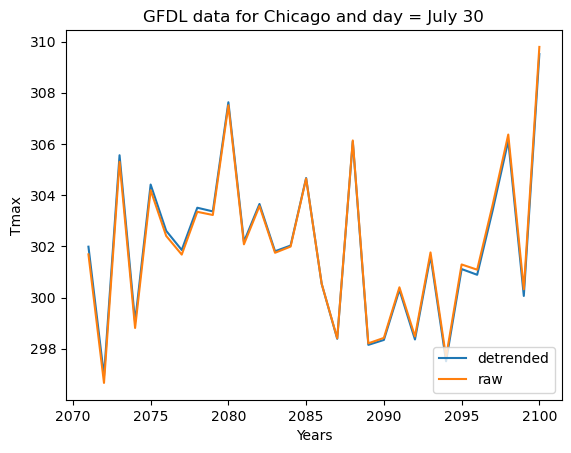

In [17]:
%%time
#Select a location and day
ds_eoc_chic    = ds_eoc_det.sel(dayofyear=doy,source_id='GFDL-ESM4').sel(lat=chicago_lat,lon=chicago_lon,method='nearest')
raw_eoc_chic   = raw_ds_eoc.sel(dayofyear=doy,source_id='GFDL-ESM4').sel(lat=chicago_lat,lon=chicago_lon,method='nearest')
#
plt.plot(np.arange(2071,2101,1),ds_eoc_chic,label='detrended')
plt.plot(np.arange(2071,2101,1),raw_eoc_chic, label ='raw')
plt.xlabel('Years')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('GFDL data for Chicago and day = ' + date)

CPU times: user 1.53 s, sys: 74.8 ms, total: 1.61 s
Wall time: 8.1 s


Text(0.5, 1.0, 'MIROC6 data for Chicago and day = July 30')

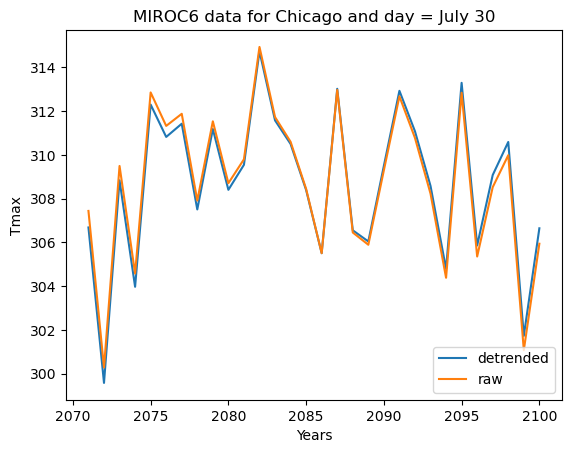

In [18]:
%%time
#Select a location and day
ds_eoc_chic    = ds_eoc_det.sel(dayofyear=doy,source_id='MIROC6').sel(lat=chicago_lat,lon=chicago_lon,method='nearest')
raw_eoc_chic = raw_ds_eoc.sel(dayofyear=doy,source_id='MIROC6').sel(lat=chicago_lat,lon=chicago_lon,method='nearest')
#
plt.plot(np.arange(2071,2101,1),ds_eoc_chic,label='detrended')
plt.plot(np.arange(2071,2101,1),raw_eoc_chic, label ='raw')
plt.xlabel('Years')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('MIROC6 data for Chicago and day = ' + date)

In [48]:
# ds_pi_det['source_id']  = ds_pi_det['source_id'].astype(str)
# ds_eoc_det['source_id'] = ds_eoc_det['source_id'].astype(str)

In [55]:
# %%time
# ds_pi_det.to_dataset().to_zarr(cmip6_cvals+'cmip6_pi_ann_detrended.zarr',mode='w')
# ds_eoc_det.to_dataset().to_zarr(cmip6_cvals+'cmip6_eoc_ann_detrended.zarr',mode='w')

CPU times: user 1min 14s, sys: 3.39 s, total: 1min 17s
Wall time: 5min 2s


In [19]:
ds_pi_det  = xr.open_zarr(cmip6_cvals+'cmip6_pi_ann_detrended.zarr').tasmax
ds_eoc_det = xr.open_zarr(cmip6_cvals+'cmip6_eoc_ann_detrended.zarr').tasmax
#
qpi  = compute_quantiles(ds_pi_det)
qeoc = compute_quantiles(ds_eoc_det)
qano = qeoc - qpi
qano

<xarray.DataArray 'tasmax' (quantile: 30, source_id: 2, dayofyear: 365,
                            lat: 181, lon: 361)>
dask.array<sub, shape=(30, 2, 365, 181, 361), dtype=float64, chunksize=(30, 1, 46, 46, 91), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
  * source_id  (source_id) <U9 'GFDL-ESM4' 'MIROC6'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

### Moment Delta Mapping : MIROC6 - ground truth , GFDL - GCM

In [20]:
miroc_pi  = ds_pi_det.sel(source_id = 'MIROC6')
miroc_eoc = ds_eoc_det.sel(source_id = 'MIROC6')
#
gfdl_pi   = ds_pi_det.sel(source_id = 'GFDL-ESM4')
gfdl_eoc  = ds_eoc_det.sel(source_id = 'GFDL-ESM4')
#
miroc_eoc

<xarray.DataArray 'tasmax' (year: 30, dayofyear: 365, lat: 181, lon: 361)>
dask.array<getitem, shape=(30, 365, 181, 361), dtype=float64, chunksize=(4, 46, 46, 91), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 ...
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
    source_id  <U9 'MIROC6'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [21]:
gfdl_pi_mean  = gfdl_pi.mean('year')
gfdl_eoc_mean = gfdl_eoc.mean('year')
gfdl_pi_std   = gfdl_pi.std('year')
gfdl_eoc_std  = gfdl_eoc.std('year')

In [22]:
miroc_mdm = implement_mdm(miroc_pi,gfdl_pi_mean,gfdl_eoc_mean,gfdl_pi_std,gfdl_eoc_std)

In [28]:
# %%time
# miroc_mdm.to_dataset().to_zarr(cmip6_cvals+'miroc6_mdm.zarr',mode='w')

CPU times: user 31.7 s, sys: 1.64 s, total: 33.4 s
Wall time: 2min 44s


#### Check MDM

In [23]:
miroc_mdm = xr.open_zarr(cmip6_cvals+'miroc6_mdm.zarr').tasmax
miroc_mdm

<xarray.DataArray 'tasmax' (dayofyear: 365, lat: 181, lon: 361, year: 30)>
dask.array<open_dataset-d16c8ab66aa1db0edf872f803b5fb48atasmax, shape=(365, 181, 361, 30), dtype=float64, chunksize=(46, 46, 91, 4), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 ...
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [24]:
qmiroc_mdm = compute_quantiles(miroc_mdm)
qmiroc_pi  = compute_quantiles(miroc_pi)
qmiroc_eoc = compute_quantiles(miroc_eoc)
#
qgfdl_pi   = compute_quantiles(gfdl_pi)
qgfdl_eoc  = compute_quantiles(gfdl_eoc)
#
qgfdl_ano  = qgfdl_eoc - qgfdl_pi 
#
qmiroc_qdm = qmiroc_pi + qgfdl_ano
qmiroc_qdm

<xarray.DataArray 'tasmax' (quantile: 30, dayofyear: 365, lat: 181, lon: 361)>
dask.array<add, shape=(30, 365, 181, 361), dtype=float64, chunksize=(30, 46, 46, 91), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

CPU times: user 2.44 s, sys: 103 ms, total: 2.55 s
Wall time: 13 s


Text(0.5, 1.0, 'MIROC + MDM (GFDL) in Chicago, January 01')

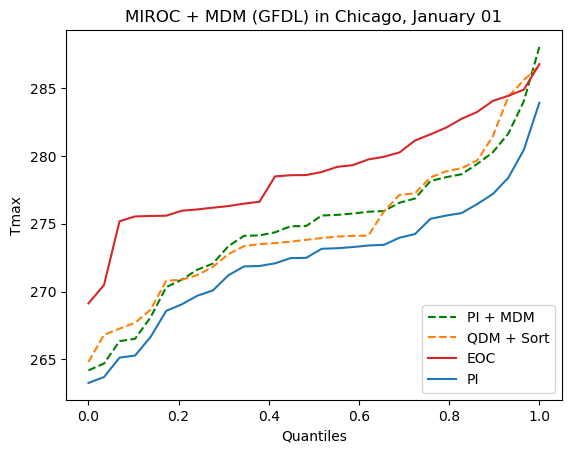

In [30]:
%%time
doy  = 1
date = no_leap_date(doy)
#
qmiroc_mdm_chic  = qmiroc_mdm.sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(dayofyear=doy)
qmiroc_qdm_chic  = qmiroc_qdm.sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(dayofyear=doy)
qmiroc_sqdm_chic = np.sort(qmiroc_qdm.sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(dayofyear=doy).values)

#
qmiroc_eoc_chic = qmiroc_eoc.sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(dayofyear=doy)
qmiroc_pi_chic  = qmiroc_pi.sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(dayofyear=doy)
qgfdl_pi_chic   = qgfdl_pi.sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(dayofyear=doy)
qgfdl_eoc_chic  = qgfdl_eoc.sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(dayofyear=doy)

#
plt.plot(quants,qmiroc_mdm_chic,'--',color='green',label='PI + MDM')
plt.plot(quants,qmiroc_sqdm_chic,'--',color='tab:orange',label='QDM + Sort')
plt.plot(quants,qmiroc_eoc_chic,color='tab:red',label ='EOC')
plt.plot(quants,qmiroc_pi_chic,color= 'tab:blue', label ='PI')
#
# plt.plot(quants,qgfdl_eoc_chic,'--', color='tab:red', label ='GFDL:EOC')
# plt.plot(quants,qgfdl_pi_chic,'--',color= 'tab:blue', label ='GFDL:PI')
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('MIROC + MDM (GFDL) in Chicago, ' + date)

CPU times: user 2.5 s, sys: 129 ms, total: 2.63 s
Wall time: 13.1 s


Text(0.5, 1.0, 'MIROC + MDM (GFDL) in Bengaluru, July 30')

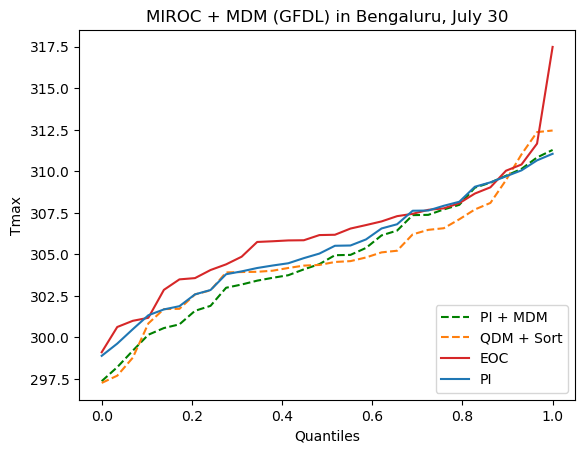

In [43]:
%%time
doy  = 211
date = no_leap_date(doy)
#
qmiroc_mdm_chic  = qmiroc_mdm.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
qmiroc_qdm_chic  = qmiroc_qdm.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
qmiroc_sqdm_chic = np.sort(qmiroc_qdm.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy).values)

#
qmiroc_eoc_chic = qmiroc_eoc.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
qmiroc_pi_chic  = qmiroc_pi.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
qgfdl_pi_chic   = qgfdl_pi.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
qgfdl_eoc_chic  = qgfdl_eoc.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)

#
plt.plot(quants,qmiroc_mdm_chic,'--',color='green',label='PI + MDM')
plt.plot(quants,qmiroc_sqdm_chic,'--',color='tab:orange',label='QDM + Sort')
plt.plot(quants,qmiroc_eoc_chic,color='tab:red',label ='EOC')
plt.plot(quants,qmiroc_pi_chic,color= 'tab:blue', label ='PI')
#
# plt.plot(quants,qgfdl_eoc_chic,'--', color='tab:red', label ='GFDL:EOC')
# plt.plot(quants,qgfdl_pi_chic,'--',color= 'tab:blue', label ='GFDL:PI')
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('MIROC + MDM (GFDL) in Bengaluru, ' + date)

In [44]:
is_sorted(qmiroc_sqdm_chic)

True

In [45]:
np.sqrt(mean_squared_error(qmiroc_eoc_chic.values,qmiroc_sqdm_chic))

1.7466132244804584

In [46]:
np.sqrt(mean_squared_error(qmiroc_eoc_chic.values,qmiroc_mdm_chic))

1.8872633879054246

CPU times: user 8.68 s, sys: 388 ms, total: 9.07 s
Wall time: 54.6 s


Text(0.5, 1.0, 'MIROC + MDM (GFDL) in Bengaluru, July 30')

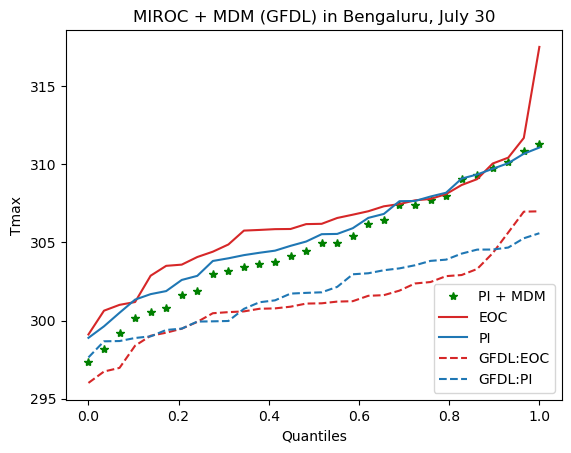

In [58]:
%%time
doy  = 211
date = no_leap_date(doy)
#
qmiroc_mdm_ben = qmiroc_mdm.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
qmiroc_eoc_ben = qmiroc_eoc.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
qmiroc_pi_ben  = qmiroc_pi.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
qgfdl_pi_ben   = qgfdl_pi.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
qgfdl_eoc_ben  = qgfdl_eoc.sel(lat=ben_lat,lon=ben_lon,method='nearest').sel(dayofyear=doy)
#
plt.plot(quants,qmiroc_mdm_ben,'*',color='green',label='PI + MDM')
plt.plot(quants,qmiroc_eoc_ben,color='tab:red',label ='EOC')
plt.plot(quants,qmiroc_pi_ben,color= 'tab:blue', label ='PI')
#
plt.plot(quants,qgfdl_eoc_ben,'--', color='tab:red', label ='GFDL:EOC')
plt.plot(quants,qgfdl_pi_ben,'--',color= 'tab:blue', label ='GFDL:PI')
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('MIROC + MDM (GFDL) in Bengaluru, ' + date)

#### Test MDM #######

In [39]:
miroc_pi.sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(dayofyear=doy).values

array([305.15046001, 306.3041887 , 303.59884757, 305.65849057,
       307.83095705, 310.958227  , 303.52913099, 304.70019366,
       315.86814355, 311.24931975, 304.0665311 , 308.90028299,
       306.88250289, 300.42642934, 306.10029963, 302.74966431,
       303.18729803, 295.36330455, 305.60107865, 302.96940695,
       301.12786587, 302.86832552, 303.62935401, 309.24154828,
       314.75745959, 303.78920952, 309.71832884, 308.02168521,
       311.85809213, 303.20930007])

In [ ]:
######################## Coded until here ######################

(0.0, 1.0)

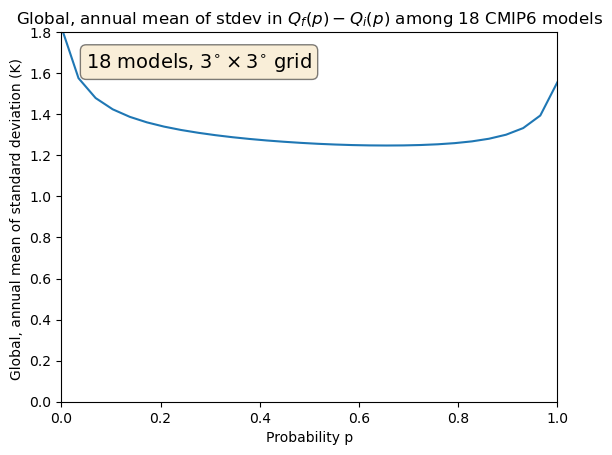

In [57]:
qano_std_agmean.plot()
plt.xlabel('Probability p')
plt.ylabel('Global, annual mean of standard deviation (K) ')
plt.title(r'Global, annual mean of stdev in $Q_f(p) -Q_i(p)$ among 18 CMIP6 models')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, r'18 models, $3^{\circ} \times 3^{\circ}$ grid', transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.ylim(0,1.8)
plt.xlim(0,1.0)

In [ ]:
#################################### Land and Ocean-only curves ########################

In [ ]:
# df_eoc_quants                  = df_eoc.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
# df_eoc_quants.columns          = ['source_id','quantiles','tasmax']
# df_eoc_quants['experiment_id'] = 'ssp370'
# df_eoc_quants

In [ ]:
# df_pi_quants                  = df_pi.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
# df_pi_quants.columns          = ['source_id','quantiles','tasmax']
# df_pi_quants['experiment_id'] = 'historical'
# df_pi_quants

In [ ]:
# df_quants = pd.concat([df_eoc_quants, df_pi_quants],ignore_index=True)
# df_quants 

In [ ]:
# g = sns.relplot(data=df_eoc_quants,x="quantiles", y="tasmax",hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, EOC tasmax at Chicago: 21 CMIP6 models')

In [ ]:
# g = sns.relplot(data=df_quants,x="quantiles", y="tasmax",hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax at Chicago: 21 CMIP6 models')

In [ ]:
############## Anomalies ###########################

In [ ]:
# # Pivot the table based on experiment_id
# df_pivot = df_quants.pivot_table(index=['source_id', 'quantiles'], columns='experiment_id', values='tasmax')
# df_pivot

In [ ]:
# # Calculate the difference
# df_pivot['tasmax_ano'] = df_pivot['ssp370'] - df_pivot['historical']
# df_pivot
# # Reset the index to turn multi-index back to columns
# df_quant_ano = df_pivot.reset_index()[['source_id', 'quantiles', 'tasmax_ano']]
# df_quant_ano

In [ ]:
# g = sns.relplot(data=df_quant_ano,x="quantiles", y="tasmax_ano",
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax anomaly at Chicago: 21 CMIP6 models')

In [ ]:
# # Group by quantiles and compute the standard deviation for Tasmax
# df_quantano_std = df_quant_ano.groupby('quantiles')['tasmax_ano'].std().reset_index()

# # Rename the column for clarity
# df_quantano_std.rename(columns={'tasmax_ano': 'tasmax_sdev'}, inplace=True)
# df_quantano_std

In [ ]:
# g = sns.relplot(data=df_quantano_std,x="quantiles", y="tasmax_sdev",
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax std at Chicago: 21 CMIP6 models')